In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pprint
import glob
from pathlib import Path
import pickle
import random

from tqdm.autonotebook import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import pandas as pd
import torch
from pytorch3d.io import save_obj
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    OpenGLPerspectiveCameras, 
    NormWeightedCompositor,
    look_at_view_transform,
    TexturesVertex,
    Textures,
    PointLights
)

import general_utils
import visualization_tools
from mesh_refiner import MeshRefiner
from evaluation import evaluate

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
device = torch.device("cuda:0")
cfg = general_utils.load_config("config.yaml")

instances = {}
instances["f390b1b28b6dda03dc57b3e43c28d486"] = {"input_img_path": "examples/f390b1b28b6dda03dc57b3e43c28d486.png", "original_mesh_path":"examples/f390b1b28b6dda03dc57b3e43c28d486.obj", "gt_mesh_path": "ground_truth/f390b1b28b6dda03dc57b3e43c28d486.obj", "azim":150, "elev":40, "dist":1.2}
instances["eb8fe6d82d195ab5bc8feea465aa74f2"] = {"input_img_path": "examples/eb8fe6d82d195ab5bc8feea465aa74f2.png", "original_mesh_path":"examples/eb8fe6d82d195ab5bc8feea465aa74f2.obj", "gt_mesh_path": "ground_truth/eb8fe6d82d195ab5bc8feea465aa74f2.obj", "azim":336, "elev":40, "dist":1.2}
instances["f6b96f56212f55363023a5c0cae3fffe"] = {"input_img_path": "examples/f6b96f56212f55363023a5c0cae3fffe.png", "original_mesh_path":"examples/f6b96f56212f55363023a5c0cae3fffe.obj", "gt_mesh_path": "ground_truth/f6b96f56212f55363023a5c0cae3fffe.obj", "azim":323, "elev":40, "dist":1.3}
instances["0146"] = {"input_img_path": "examples/0146.png", "original_mesh_path":"examples/0146.obj", "gt_mesh_path": "ground_truth/0146.obj", "azim":69, "elev":22, "dist":1.1}
instances["OWILD_White_Toy_Rv_090"] = {"input_img_path": "examples/OWILD_White_Toy_Rv_090.png", "original_mesh_path":"examples/OWILD_White_Toy_Rv_090.obj", "gt_mesh_path": "ground_truth/White_Toy_Rv.obj", "azim":175, "elev":6, "dist":1}
instances["OOWL_Alta_Dena_Whipped_Cream_Can_090"] = {"input_img_path": "examples/OOWL_Alta_Dena_Whipped_Cream_Can_090.png", "original_mesh_path":"examples/OOWL_Alta_Dena_Whipped_Cream_Can_090.obj", "gt_mesh_path": "ground_truth/Alta_Dena_Whipped_Cream_Can.obj", "azim":189, "elev":8, "dist":1}

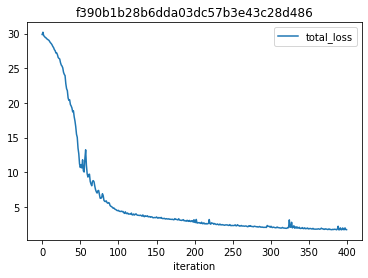

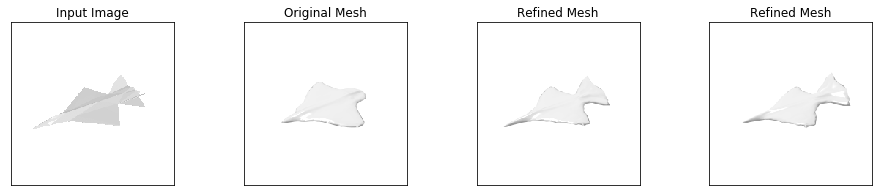

f_score: 0.5556610050779198 -> 0.6317165726322125
chamfer_L2: 12.677155435085297 -> 6.3070571050047874


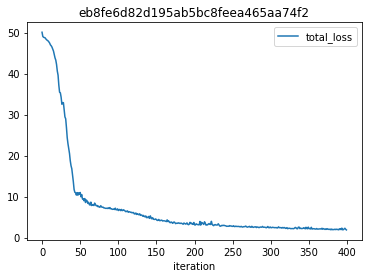

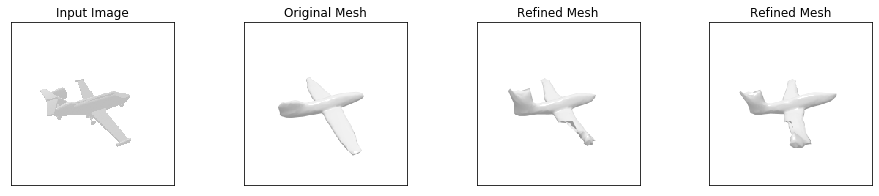

f_score: 0.7529306703217806 -> 0.7951991667703022
chamfer_L2: 13.128192164003849 -> 9.63914766907692


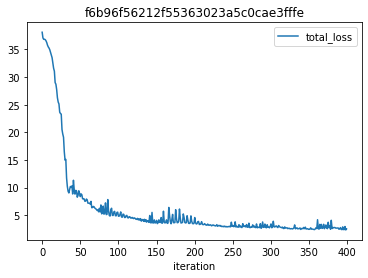

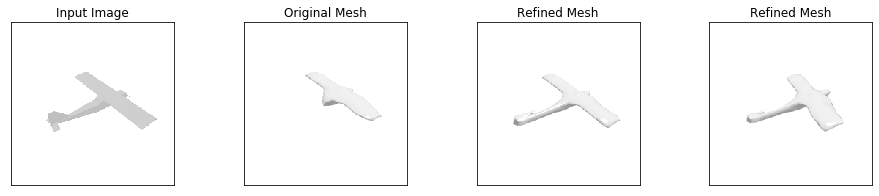

f_score: 0.41834683877136364 -> 0.7797800025621316
chamfer_L2: 55.150389671325684 -> 4.14326274767518


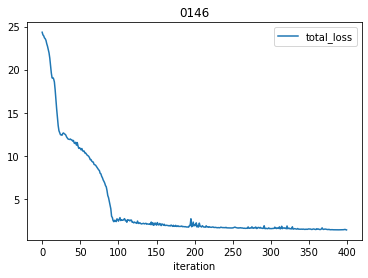

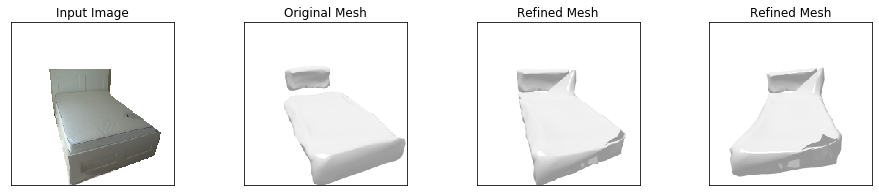

f_score: 0.5294395453295444 -> 0.5245626275746892
chamfer_L2: 20.982997491955757 -> 17.815496772527695


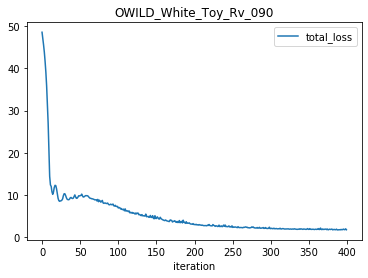

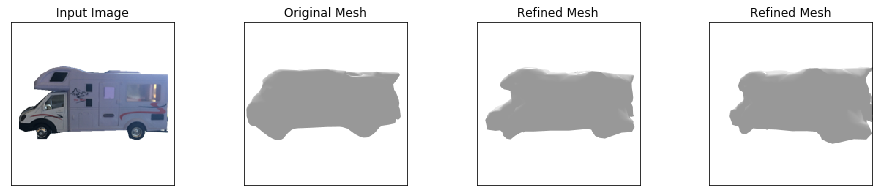

f_score: 0.6298858230860769 -> 0.6354814756548414
chamfer_L2: 7.533813361078501 -> 6.10123947262764


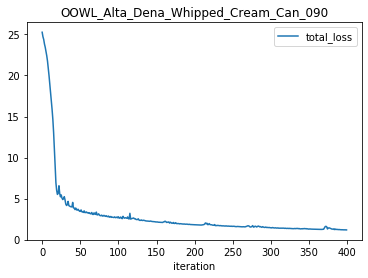

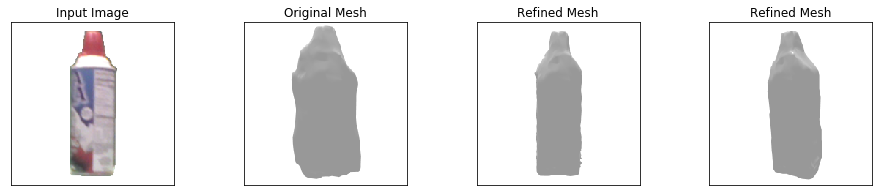

f_score: 0.4423027656477438 -> 0.4430363166179446
chamfer_L2: 15.281867235898972 -> 13.60512524843216


In [4]:
for instance_name in instances:
    # setting up
    input_img_path = instances[instance_name]["input_img_path"]
    original_mesh_path = instances[instance_name]["original_mesh_path"]
    azim = instances[instance_name]["azim"]
    elev = instances[instance_name]["elev"]
    dist = instances[instance_name]["dist"]
    input_image = np.asarray(Image.open(input_img_path))
    with torch.no_grad():
        input_mesh = general_utils.load_untextured_mesh(original_mesh_path, device)
    R, T = look_at_view_transform(dist, elev, azim)
    
    # performing REFINE
    mesh_refiner = MeshRefiner(cfg, device)
    refined_mesh, refinement_info = mesh_refiner.refine_mesh(input_mesh, input_image, R, T, record_debug=True)
    
    # plotting loss, visualizing results, and saving refined mesh
    refined_mesh_path = os.path.join("REFINEd_output", "{}_refined.obj".format(instance_name))
    save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
    refined_mesh = general_utils.load_untextured_mesh(refined_mesh_path, device)
    refinement_info["loss_info"].plot.line(x='iteration', y='total_loss', title="{}".format(instance_name))
    visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, R, T, device, num_novel_view=1)
    
    # evaluation
    gt_mesh_path = instances[instance_name]["gt_mesh_path"]
    metrics_before = evaluate(original_mesh_path, gt_mesh_path, device)
    metrics_after = evaluate(refined_mesh_path, gt_mesh_path, device)
    for metric in metrics_before:
        print("{}: {} -> {}".format(metric, metrics_before[metric], metrics_after[metric]))
    